In [9]:
%load_ext autoreload
%autoreload 2
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
import scipy
import scipy.linalg

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from typing import Tuple

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

rng = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Useful functions

In [10]:
def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [11]:
def synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [12]:
wavefile = load_sound('clocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [13]:
play = True
if play :
    play_sound('clocheB.WAV')

Expression 'paInvalidSampleRate' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 2043
Expression 'PaAlsaStreamComponent_InitialConfigure( &self->playback, outParams, self->primeBuffers, hwParamsPlayback, &realSr )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 2716
Expression 'PaAlsaStream_Configure( stream, inputParameters, outputParameters, sampleRate, framesPerBuffer, &inputLatency, &outputLatency, &hostBufferSizeMode )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 2837


OSError: [Errno -9997] Invalid sample rate

In [14]:
T, data, nframes, nchannels, sampling_frequency = read_values('clocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

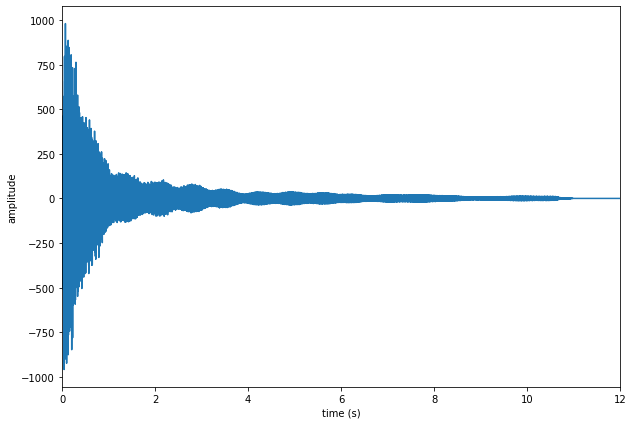

In [15]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [16]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

In [17]:
f_n = [0.5, 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7, 3, 3.3, 3.7, 4.2, 4.5, 5, 5.9]
f_n = np.array(f_n)
alpha_n = lambda f_p: f_n / f_p

## Partie 1 : Signal synthétique

### Analyse spectrale par transformation de Fourier

In [18]:
n = 63
delta_f = 1/n
f = np.array([0.25, 0.25 + delta_f])
a = np.array([1, 10])
delta = np.array([0, -0.05])
phi = rng.uniform(-np.pi, np.pi, (2,))

x = synthesis(n, delta=delta, f=f, a=a, phi=phi)

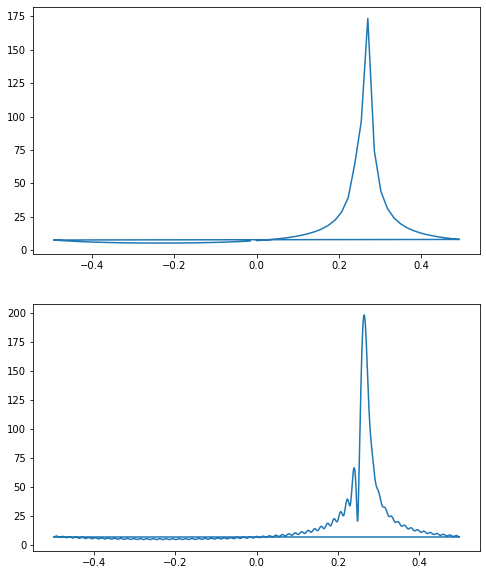

In [19]:
plt.figure(figsize=(8, 10))
n_fft = n
x_ft_1 = np.fft.fft(x, n=n_fft)
freqs = np.fft.fftfreq(n_fft)
plt.subplot(2, 1, 1)
plt.plot(freqs, np.abs(x_ft_1))

n_fft = 1024
x_ft_2 = np.fft.fft(x, n=n_fft)
freqs = np.fft.fftfreq(n_fft)
plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(x_ft_2))

Les deux raies sont difficilement séparable, même en augmentant la résolution numérique. 
Il faut employer une méthode à haute résolution.

### 3.2 Méthodes à haute résolution

In [22]:
def get_x_hankel(x: np.ndarray, n: int) -> np.ndarray:
    """Comme décrit dans 3.2.1

    Args:
        x (np.ndarray): [description]
        n (int): [description]

    Returns:
        np.ndarray: [description]
    """
    return scipy.linalg.hankel(x[:n], r=x[n-1:])

def get_correlation_mat(x: np.ndarray, n: int) -> np.ndarray:
    x_h = get_x_hankel(x, n)
    l = x.shape[0] - n + 1
    return x_h @ x_h.transpose().conj() / l

def get_w(x: np.ndarray, n: int, k: int) -> Tuple[np.ndarray, np.ndarray]:
    r_xx  = get_correlation_mat(x, n)

    u_1, s, u_2 = scipy.linalg.svd(r_xx)
    sigma = scipy.linalg.diagsvd(s, r_xx.shape[0], r_xx.shape[1])

    # sigma_w = sigma[:k]
    # sigma_u_1 = u_1[:,:k]
    # sigma_u_2 = u_1.transpose().conj()[:,:k]
    # w = sigma_u_1 @ sigma_w @ sigma_u_2
    # w = sigma[:k,:k]
    w = u_1[:, :k]

    # sigma_w_t = sigma[k:]
    # sigma_u_1 = u_1[:,k:]
    # sigma_u_2 = u_1.transpose().conj()[:,k:]
    # w_t = sigma_u_1 @ sigma_w_t @ sigma_u_2
    # w_t = sigma[k:,k:]
    w_t = u_1[:, :k]
    return w, w_t

def esprit(x: np.ndarray, n: int, k: int) -> Tuple[np.ndarray, np.ndarray]:
    w, w_t = get_w(x, n, k)
    w_down, w_up = w[:-1], w[1:]
    phi = scipy.linalg.pinv(w_down) @ w_up
    z = scipy.linalg.eig(phi, left=False, right=False)
    delta = np.log(np.abs(z))
    f =  np.angle(z) / (2 * np.pi)
    return delta, f

def least_squares(x: np.ndarray, delta: np.ndarray, f: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Il nous faut la matrice de Vandermonde    
    # avec $z_k = e^{\delta_k + i2\pi f_k}$
    z_exp = delta + 2j * np.pi * f
    v = np.exp(np.outer(np.arange(x.shape[0]), z_exp))
    alpha = scipy.linalg.pinv(v) @ x
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

little_n = 8
k = 2
w, w_t = get_w(x, little_n, k)
delta_est, f_est = esprit(x, little_n, k)
a_est, phi_est = least_squares(x, delta, f)
err_delta = np.linalg.norm(delta - delta_est)
err_f = np.linalg.norm(f - f_est)
err_a = np.linalg.norm(a - a_est)
err_phi = np.linalg.norm(phi - phi_est)
print(err_delta, err_f, err_a, err_phi)


0.07071067811866051 0.02244783432338203 3.3306690738754696e-16 6.661338147750939e-16


On obtient bien les paramètres $\delta, f, a$ et $\phi$ avec lesquels on avait synthétisé $x$.


(1000, 1000)


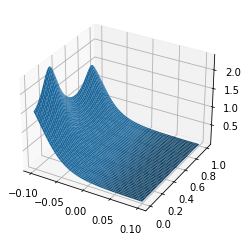

In [25]:

def p(w_t: np.ndarray, delta: np.ndarray, f: np.ndarray) -> np.ndarray:
    n = w_t.shape[0]
    z = np.exp(delta + 2j * np.pi * f)
    zs = z[..., np.newaxis]
    zs = np.tile(zs, tuple(np.ones_like(z.shape)) + (n,))
    # print(zs.shape)
    nu = np.power(zs, np.arange(n))
    # print(w_t.shape, nu.shape)
    # print(w_t.T.shape, nu.T.shape)
    prod = np.tensordot(w_t.T.conj(), nu.T, axes=(-1, 0))
    # print(np.amax(nu))
    # print(np.amax(w_t))
    # p = 1 / np.tensordot(prod, prod.conj(), axes=(0,0))
    p = 1 / np.linalg.norm(prod, axis=0)
    # print(p.shape)
    # print(prod)
    return p

def music(x: np.ndarray, n: int, k: int) -> np.ndarray:
    raise NotImplemented

# print(little_n, w_t.shape, delta.shape, f.shape)

nb_steps = 1000
fs = np.linspace(0, 1, nb_steps)
deltas = np.linspace(-0.1, 0.1, nb_steps)
deltadelta, ff = np.meshgrid(fs, deltas)
pp = p(w_t, deltadelta, ff)
ax = plt.axes(projection='3d')
ax.plot_surface(ff, deltadelta, pp)
# plt.imshow(pp, aspect='auto')
print(pp.shape)
plt.show()